<a href="https://colab.research.google.com/github/prajagopal1992/Projects-2023/blob/main/Classify_Images_of_Damaged_Cars_vs_Not_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [3]:
def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [14]:
urls = search_images('damaged car pictures', max_images=1)
urls[0]

Searching for 'damaged car pictures'


'https://vermontrepublic.org/wp-content/uploads/2020/05/Car-Damage.jpeg'

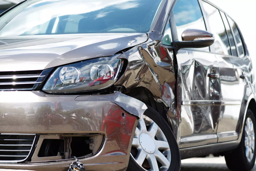

In [15]:
from fastdownload import download_url
dest = 'damaged_car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'intact car pictures'


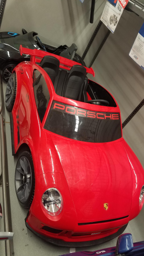

In [16]:
download_url(search_images('intact car pictures', max_images=1)[0], 'intact_car.jpg', show_progress=False)
Image.open('intact_car.jpg').to_thumb(256,256)

In [17]:
searches = 'damaged car','intact car'
path = Path('damaged_car_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'damaged car photo'
Searching for 'intact car photo'


In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

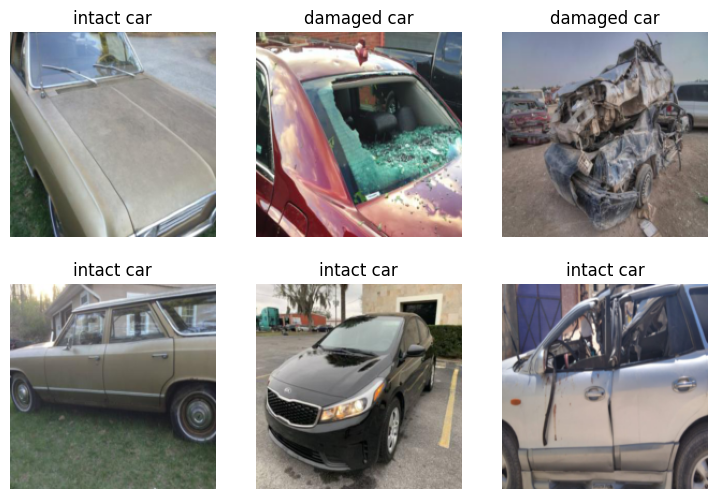

In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.995380,2.418428,0.600000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.453929,2.151361,0.500000,00:00
1,1.233835,1.904668,0.500000,00:00
2,1.021445,1.741753,0.500000,00:00


In [21]:
is_damaged_car,_,probs = learn.predict(PILImage.create('damaged_car.jpg'))
print(f"This is a: {is_damaged_car}.")
print(f"Probability it's a damaged car: {probs[0]:.4f}")

This is a: damaged car.
Probability it's a damaged car: 0.8858
